# Holidays data

Investigating the holidays datasets.

Lets start with loading the data.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from definitions import HOLIDAY_EVENTS_FILE, TRAIN_FILE

# load holiday dataframe and training data.
holiday_df = pd.read_csv(HOLIDAY_EVENTS_FILE, parse_dates=['date'])
train_df = pd.read_csv(TRAIN_FILE, parse_dates=['date'])

# Create a dataset with daily figures.
daily_figures = train_df.groupby('date').sum()[['sales']]

# Add sales data to holidays dataframe.
start_date = train_df.date.min()
end_date = train_df.date.max()
holiday_df = holiday_df[holiday_df.date.between(start_date, end_date)]
holiday_df = holiday_df.merge(daily_figures, on='date', how='left')

Lets see if we have sales numbers for every holiday.

In [2]:
print(holiday_df[holiday_df.sales.isna()])

          date     type    locale locale_name description  transferred  sales
48  2013-12-25  Holiday  National     Ecuador     Navidad        False    NaN
114 2014-12-25  Holiday  National     Ecuador     Navidad        False    NaN
167 2015-12-25  Holiday  National     Ecuador     Navidad        False    NaN
253 2016-12-25  Holiday  National     Ecuador     Navidad        False    NaN


It looks like there is no sales data on the first day of christmas. Most likely the stores are closed on this day. So we replace the Nan's with 0.

In [3]:
holiday_df = holiday_df.fillna(0)

In [4]:
print(f"Average daily sales is {round((daily_figures['sales'] / 1_000_000).mean(), 2)} mln (nationally).")

Average daily sales is 0.64 mln.


The dataset contains information about the type of holiday and where it is celebrated, this can be national local or regional.
Let's plot the average sales figures by locale.

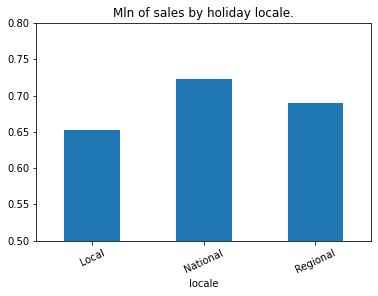

In [11]:
(holiday_df.groupby('locale').mean()['sales'] / 1_000_000).plot(kind='bar', rot=25, ylim=(0.5, 0.8), title='Mln of sales by holiday locale.')
plt.show()

The larger the locality, the larges the average sales quantity, which makes sense.

Now let's plot the average sales by holiday type.

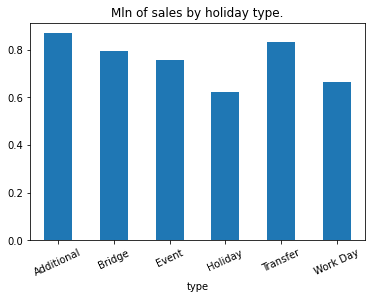

In [6]:
(holiday_df.groupby('type').mean()['sales'] / 1_000_000).plot(kind='bar', rot=25, title='Mln of sales by holiday type.')
plt.show()

Sales vary by holiday type transferred holidays and additional days are most popular for shopping.

## Number of holidays
To see the number of off-days we add the weekends, (national) holidays that have not been transferred to another date and subtract the holiday's of type 'work day'.

In [7]:
is_off_day = (holiday_df['transferred'] == False) & (holiday_df['locale'] == 'National')
is_work_day = holiday_df['type'] == 'Work Day'
holiday = holiday_df[is_off_day & (False == is_work_day)]
extra_work_days = holiday_df[is_work_day]

daily_figures['weekend_day'] = daily_figures.index.day_of_week.isin([5, 6])
daily_figures['holiday'] = daily_figures.index.isin(holiday.date.values)
daily_figures['work_day'] = (daily_figures['weekend_day'] == False) & \
                            (daily_figures['holiday'] == False) & \
                            (daily_figures.index.isin(extra_work_days.date.values) == False)

print(daily_figures['work_day'].value_counts(normalize=True))

True     0.659145
False    0.340855
Name: work_day, dtype: float64


64 percent of all days are work day's.

## Correlation

Now lets find out which variables are most salient in predicting the sales on a holiday.
Some simple linear regression should help us.

First we create a function that encodes the data and fits a regression model.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

def linear_regression(X, y):
    # one-hot encode the data.
    encoder = OneHotEncoder()
    encoder.fit(X)
    X_transformed = encoder.transform(X)

    # create a regressor, train it and get a score.
    regressor = LinearRegression()
    regressor.fit(X_transformed, y)
    score = regressor.score(X_transformed, y)

    return score


We can use the type, locale, locale_name and transferred columns to predict sales. With this limited number of columns we can just try all possible combinations.

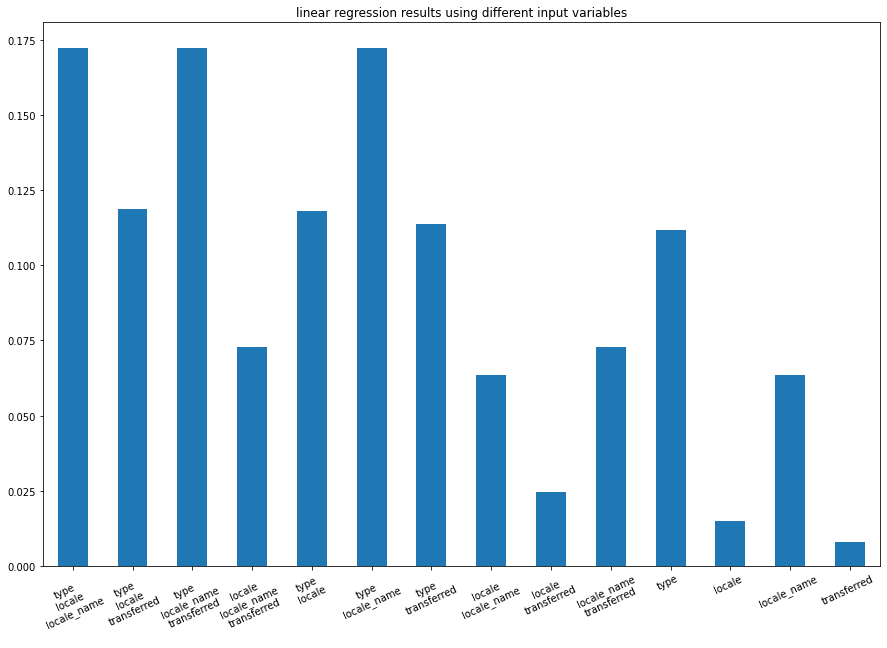

In [9]:
from itertools import combinations

# Create every possible combination of the predictor columns.
predictor_columns = ['type', 'locale', 'locale_name', 'transferred']
predictor_col_combos = []
for r in range(1, len(predictor_columns)):
    predictor_col_combos = list(combinations(predictor_columns, r)) + predictor_col_combos

# Do regression with all the combinations.
results = []
y = holiday_df.sales
for col_combination in predictor_col_combos:
    X = holiday_df[list(col_combination)]
    score = linear_regression(X, y)
    results.append(score)

# Display results in a bar chart.
index = [''.join([c + '\n' for c in columns]) for columns in predictor_col_combos]
results_df = pd.Series(results, index=index)
results_df.plot(kind='bar', rot=25, title='linear regression results using different input variables', figsize=(15, 10))
plt.show()


Combinations that contain holiday type and locale_name seem to preform the best, lets see the coefficients.

In [18]:
# scale sales data to thousands, for readability.
holiday_df['sales'] = holiday_df['sales'] / 1000

# encode data.
encoder = OneHotEncoder()
X = holiday_df[['type', 'locale_name']]
encoder.fit(X)
X_transformed = encoder.transform(X)

# create and fit regression model.
regressor = LinearRegression()
regressor.fit(X_transformed, y)
score = regressor.score(X_transformed, y)

# create series with coefficients, sort and print.
types = [type + ' (type)' for type in encoder.categories_[0]]
locale_names = [locale + ' (locale)' for locale in encoder.categories_[1]]
coefficients = dict(zip(types + locale_names, regressor.coef_))
print('Linear regression coefficients.')
print(pd.Series(coefficients).sort_values(ascending=False))


Linear regression coefficients.
Salinas (locale)                           34.707794
Additional (type)                          12.343813
Cotopaxi (locale)                          11.287465
Santo Domingo (locale)                     10.814593
El Carmen (locale)                         10.814593
Transfer (type)                             9.231839
Manta (locale)                              4.673761
Loja (locale)                               4.298693
Santo Domingo de los Tsachilas (locale)     4.255505
Bridge (type)                               4.246667
Santa Elena (locale)                        2.923999
Ibarra (locale)                             2.015492
Cayambe (locale)                            0.724424
Event (type)                                0.488288
Esmeraldas (locale)                        -0.478665
Quito (locale)                             -1.867812
Imbabura (locale)                          -2.204539
Machala (locale)                           -2.204539
Riobamba (loca